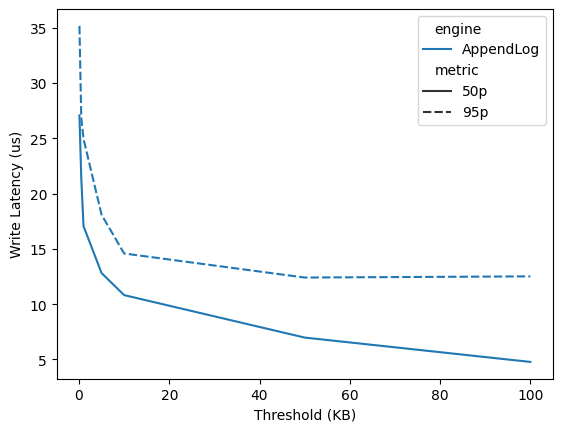


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{threshold_write.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, 10second sample for each average latency measurement}
    \label{fig:threshold_write.png}
\end{figure}



In [32]:
# writes

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_threshold(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [AppendLog], [{
        'max_runs_per_level': [3],
        'threshold': [100, 500, 1000, 5000, 10000, 50000, 100000],
        'replica': [None]
    }],
    [measure_threshold], {}
)


data = df[['threshold', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us
data['threshold'] = data['threshold'] /1000   #us

lineplot(data, 'threshold', 'value', 'threshold_write',
         hue='engine',
         style='metric',
         X='Threshold (KB)', Y='Write Latency (us)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, 10second sample for each average latency measurement',
         save=True, show=True)

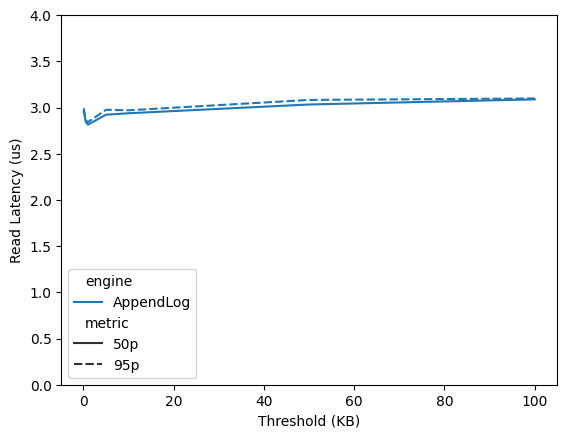


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{threshold_read.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, 10second sample for each average latency measurement}
    \label{fig:threshold_read.png}
\end{figure}



In [33]:
# reads


import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_threshold(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [2]}],
    [AppendLog], [{
        'max_runs_per_level': [3],
        'threshold': [100, 500, 1000, 5000, 10000, 50000, 100000],
        'replica': [None]
    }],
    [measure_threshold], {}
)


data = df[['threshold', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us
data['threshold'] = data['threshold'] /1000

lineplot(data, 'threshold', 'value', 'threshold_read',
         hue='engine',
         style='metric',
         X='Threshold (KB)', Y='Read Latency (us)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, 10second sample for each average latency measurement',
         ylim=(0, 4),
         save=True, show=True)



/tmp/ipykernel_84/4193761826.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['threshold'] = data['threshold'] /1000   #us


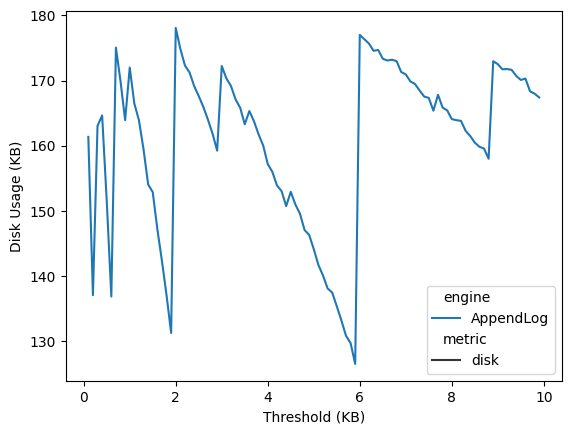


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{threshold_write.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, writing the whole state (10k kvpairs), uniform distrib, max_runs_per_level: 3}
    \label{fig:threshold_write.png}
\end{figure}



In [31]:
# disk

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_threshold(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    for k, v in zip(keys_set, vals_set):
        db[keys_set[next(distro)]] = vals_set[next(distro)]

    res.append({'metric': 'disk', 'value': get_dir_size_bytes(db.data_dir) / 1000})

    return res


df = run(
    [4], [4], [20_000], [0],
    [Uniform], [{'seed': [1]}],
    [AppendLog], [{
        'max_runs_per_level': [3],
        'threshold': list(range(100, 10000, 100)),
        'replica': [None]
    }],
    [measure_threshold], {}
)


data = df[['threshold', 'metric', 'value', 'engine']]
data['threshold'] = data['threshold'] /1000   #us




def lineplot(data, x, y, filename,
             hue=None, style=None,
             title=None, ylim=None,
             x_log=False,
             caption=None, X=None, Y=None,
             save=True, show=False):
    filename += '.png'
    plot = sns.lineplot(data=data, x=x, y=y, hue=hue, style=style)
    if title:
        plot.set_title(title)
    if X:
        plot.set_xlabel(X)
    if Y:
        plot.set_ylabel(Y)
    if ylim is not None:
        plot.set(ylim=ylim)
    if x_log:
        plot.set(xscale='log')

    fig = plot.get_figure()

    if save:
        fig.savefig(f"{figures_dir}/{filename}")
    if show:
        plt.show()

    if not caption:
        caption = filename

    print(f'''
\\begin{{figure}}[h]
    \centering
    \includegraphics[width=0.25\\textwidth]{{{filename}}}
    \caption{{{caption}}}
    \label{{fig:{filename}}}
\end{{figure}}
''')



lineplot(data, 'threshold', 'value', 'threshold_disk',
         hue='engine',
         style='metric',
         X='Threshold (KB)', Y='Disk Usage (KB)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, writing the whole state (10k kvpairs), uniform distrib, max_runs_per_level: 3',
         save=True, show=True)

# not using